In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/data/nihaifeng/code/HeliosArtifact/simulator')
import utils

In [ ]:
trace_dir = '/data/nihaifeng/code/HeliosArtifact/simulator/data/Philly'
vc_dict = pd.read_pickle(trace_dir+'/vc_dict_homo.pkl')
trace_range = ('2017-10-01 00:00:00', '2017-11-30 23:59:00')

for muation in [False]:
	trace_df, _ = utils.trace_philly_process(trace_dir, trace_range, vc_dict, muation)
	print(trace_df.describe())

In [ ]:
# 文件路径
file_path = "/data/nihaifeng/log/star1/nohup/defragS_sdf.out"

# 初始化计数器
migrate_count = 0

# 打开文件并逐行读取
with open(file_path, "r", encoding="utf-8") as file:
	for line in file:
		# 检查 "MIGRATE" 是否在当前行中
		if "MIGRATE" in line:
			migrate_count += 1

# 输出结果
print(f"含有 'MIGRATE' 的行的数量: {migrate_count}")


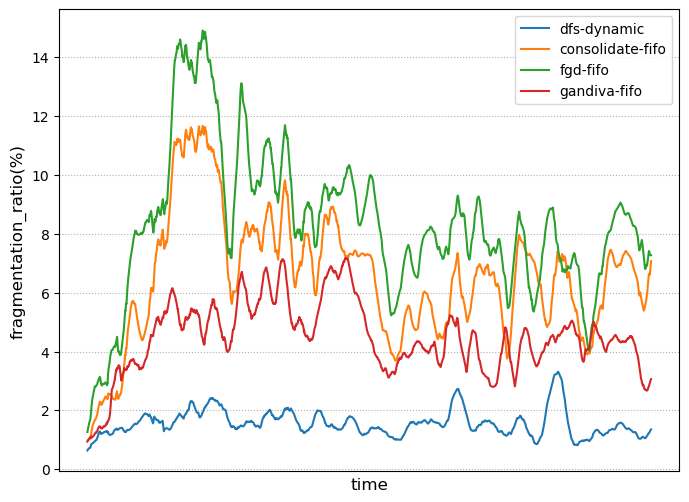

In [20]:
schedulers = ["defragS_dynamic","fifo_consolidate", "fifo_FGD", "gandiva_fifo"]
labels = ["dfs-dynamic", "consolidate-fifo", "fgd-fifo", "gandiva-fifo"]
log_dir = "/data/nihaifeng/log/test/Philly" 

# schedulers = ["defragS_sdf", "sjf_consolidate", "sjf_FGD", "gandiva_sjf", "defragS_sjf", "defragS_short"]
# labels = ["dfs-sdf", "consolidate", "fgd", "gandiva", "dfs-sjf", "dfs-srf"]
# log_dir = "/data/nihaifeng/log/Philly_sjf" 

saving = False
window_size = 60 * 24 * 1

utilization = 'fragmentation_ratio' #
fig = plt.figure(figsize=(8,6))
for idx, scheduler in enumerate(schedulers):
	df = pd.read_csv(log_dir+f'/Philly_{scheduler}/all/{scheduler}_all_seq.csv')
	y = df[utilization]*100
	plt.plot(df['time'], y.rolling(window=window_size).mean(), label=labels[idx])

plt.xlabel('time', fontsize=12)
plt.xticks([])
plt.ylabel(f'{utilization}(%)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(linestyle=':')
plt.show()

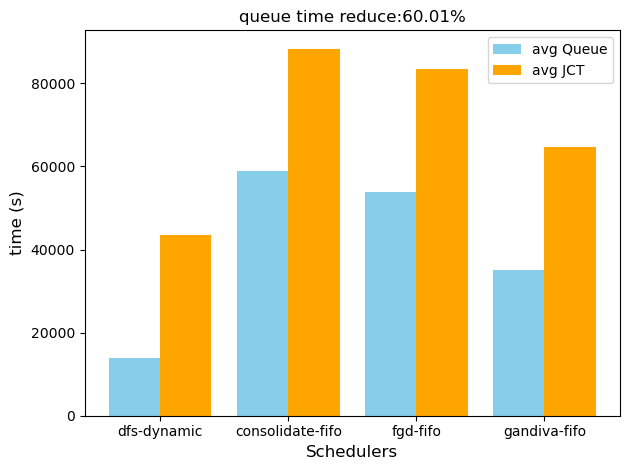

que_list:  [14005, 58800, 53929, 35020]
jct_list:  [43543, 88339, 83468, 64558]


In [4]:
que_list, jct_list = [], []
for scheduler in schedulers:
	df = pd.read_csv(log_dir+f'/Philly_{scheduler}/jct_avg.csv')
	jct_list.append(df.iloc[len(df)-1, 1])
	df = pd.read_csv(log_dir+f'/Philly_{scheduler}/que_avg.csv')
	que_list.append(df.iloc[len(df)-1, 1])
		

# 设置柱状图的宽度和位置
x_indices = np.arange(len(schedulers))  # x 轴位置
bar_width = 0.4  # 每个柱的宽度


# 绘制两组柱状图
plt.bar(x_indices - bar_width/2, que_list, bar_width, label='avg Queue', color='skyblue')
plt.bar(x_indices + bar_width/2, jct_list, bar_width, label='avg JCT', color='orange')

# 设置 x 轴标签
plt.xticks(x_indices, labels)
# plt.yticks([])

# 添加标题和坐标轴标签
plt.xlabel("Schedulers", fontsize=12)
plt.ylabel("time (s)", fontsize=12)

# 添加图例
plt.legend()

# 显示图表
dfs = que_list[0]
tmp = que_list[1:]
plt.title( f'queue time reduce:{(min(tmp)-dfs)/min(tmp)*100:.2f}%', fontsize=12)
plt.tight_layout()
plt.show()
print("que_list: ", que_list)
print("jct_list: ", jct_list)

/tmp/ipykernel_3891977/1502584678.py:15: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(x_min, x_max)  # 设置 x 轴范围


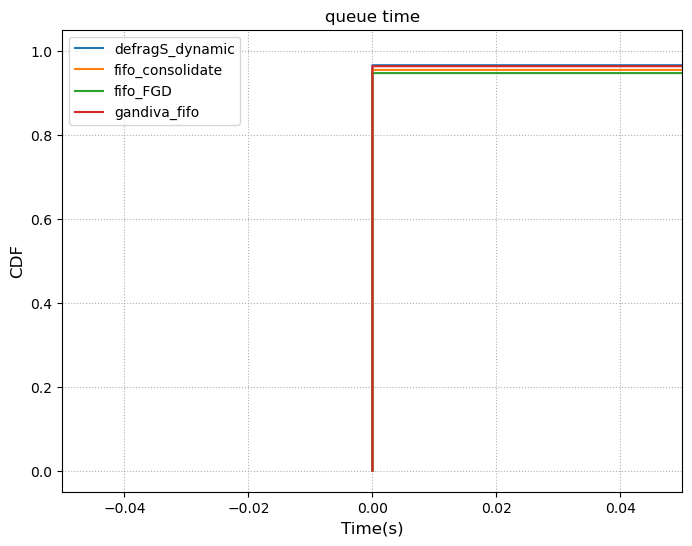

In [38]:
data_type = "queue"
cluster = '6c71a0'  # ['7f04ca', 'ed69ec', '6214e9', '0e4a51', 'b436b2', '103959', '11cb48', '2869ce', 'ee9e8c', 'e13805', '6c71a0'] 'all'

fig = plt.figure(figsize=(8,6))
for idx, scheduler in enumerate(schedulers):
	df = pd.read_csv(log_dir+f'/Philly_{scheduler}/{cluster}/{scheduler}_{cluster}_log.csv')
	# df = df[df['gpu_num'] >= 16]
	y = df[data_type]
	sorted_y = np.sort(y)
	cdf = np.arange(1, len(sorted_y) + 1) / len(sorted_y)
	plt.plot(sorted_y, cdf, label=scheduler)

x_min = np.min(sorted_y)
x_max = np.percentile(sorted_y, 95)  # 选择中位数作为最大范围
plt.xlim(x_min, x_max)  # 设置 x 轴范围

plt.title(f"{data_type} time")
plt.xlabel('Time(s)', fontsize=12)
plt.ylabel('CDF', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(linestyle=':')
plt.show()

相同调度算法时，SJF的Queue Time就是比FIFO好很多，无论大作业还是小作业。虽然可能存在不公平现在，但不公平之后的Queue Time也比公平的FIFO好很多

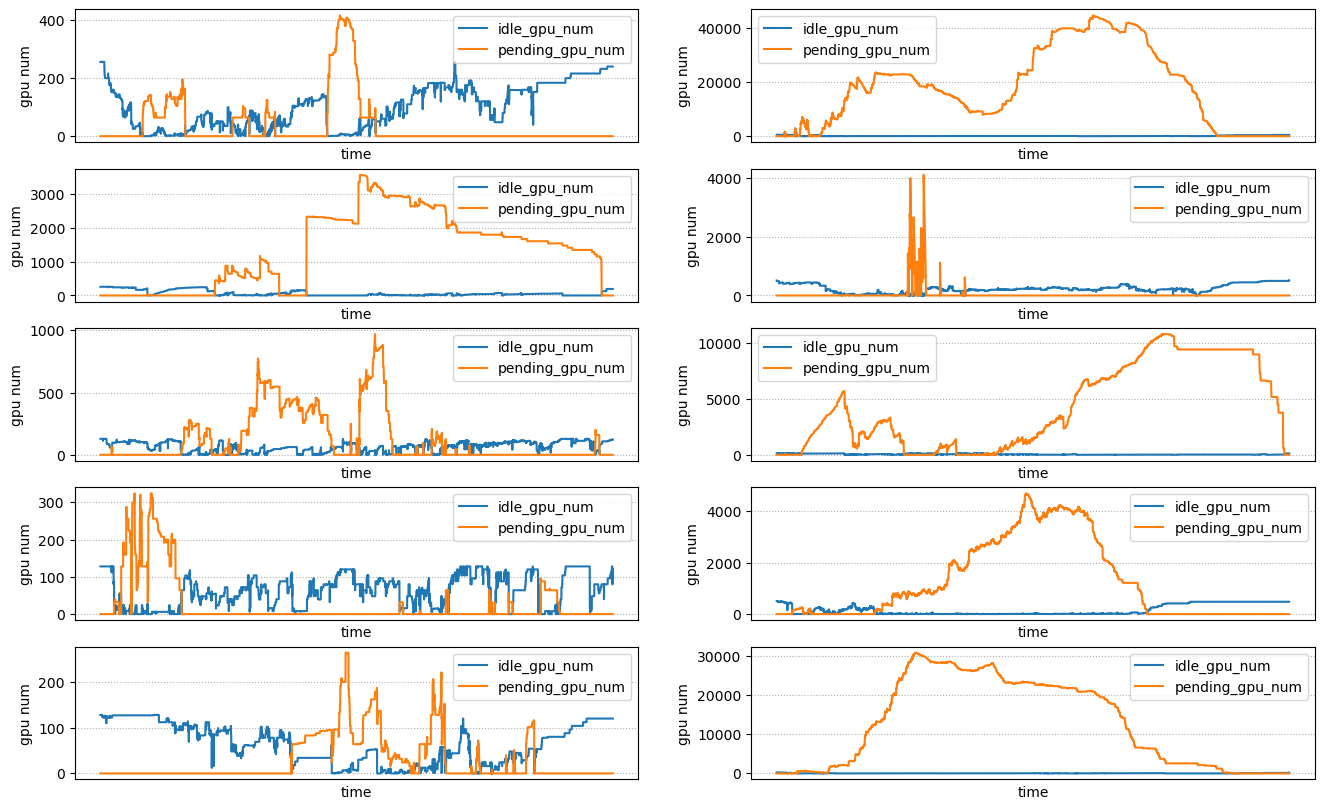

In [67]:
# 画每个VC的pending_gpu_num, idle_gpu_num 曲线
import os
schedulers = ["defragS_short", "fifo_consolidate", "fifo_FGD", "gandiva_fifo"]
log_dir = "/data/nihaifeng/log/Philly_fifo" 

vc_ls = os.listdir(log_dir + f'/Philly_{schedulers[0]}')
vc_ls.remove('all')
vc_ls.remove('logfile')
vc_ls.remove('jct_avg.csv')
vc_ls.remove('que_avg.csv')

scheduler = schedulers[0]

fig, axes = plt.subplots(5, 2, figsize=(16,10))
axes = axes.flatten() 
for idx, vc in enumerate(vc_ls):
	ax = axes[idx]
	df = pd.read_csv(log_dir + f'/Philly_{scheduler}/{vc}/{scheduler}_{vc}_seq.csv')
	ax.plot(df['idle_gpu_num'], label='idle_gpu_num')
	ax.plot(df['pending_gpu_num'], label='pending_gpu_num')
	ax.set_ylabel('gpu num')
	ax.legend(loc='best')
	ax.set_xlabel('time')
	ax.set_xticks([])
	ax.grid(linestyle=':')
plt.show()


In [26]:
# 在每个VC中话不同调度算法的fragmentation_ratio或gpu_utilization曲线

# schedulers = ["fifo_consolidate", "fifo_FGD", "gandiva_fifo", "defragS_short"]
# log_dir = "/data/nihaifeng/log/test/Philly_fifo" 
window_size = 60 * 24
data_type = 'fragmentation_ratio'#
vc_dict = pd.read_pickle("/data/nihaifeng/code/HeliosArtifact/simulator/data/Philly/vc_dict_homo.pkl")

vc_ls = os.listdir(log_dir + f'/Philly_{schedulers[0]}')
vc_ls.remove('all')
vc_ls.remove('logfile')
vc_ls.remove('jct_avg.csv')
vc_ls.remove('que_avg.csv')

fig, axes = plt.subplots(6, 2, figsize=(16,20))
axes = axes.flatten() 
for idx, vc in enumerate(vc_ls):
	ax = axes[idx]
	for scheduler in schedulers:
		df = pd.read_csv(log_dir + f'/Philly_{scheduler}/{vc}/{scheduler}_{vc}_seq.csv')
		y = df[data_type]*100
		ax.plot(df['time'], y.rolling(window=window_size).mean(), label=scheduler)
	ax.set_ylabel(data_type)
	ax.set_xlabel('time')
	ax.set_title(f'{vc}, host num: {vc_dict[vc]}')
	ax.set_xticks([])
	ax.grid(linestyle=':')
	ax.legend(loc='best')
plt.show()
	

['7f04ca', 'ed69ec', '6214e9', '0e4a51', 'b436b2', '103959', '11cb48', '2869ce', 'ee9e8c', 'e13805', '6c71a0']


SyntaxError: 'return' outside function (2488626631.py, line 15)

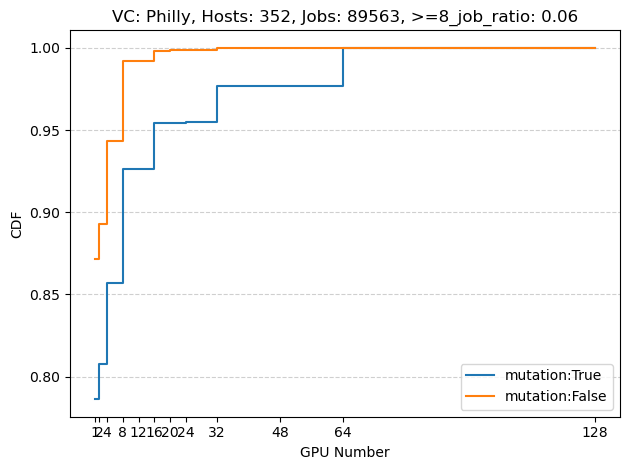

In [5]:
###### jog req GPUs CDF 
trace_dir = '/data/nihaifeng/code/HeliosArtifact/simulator/data/Philly'
vc_dict = pd.read_pickle(trace_dir+'/vc_dict_homo.pkl')
trace_range = ('2017-10-01 00:00:00', '2017-11-30 23:59:00')

for muation in [True, False]:
	trace_df, _ = utils.trace_philly_process(trace_dir, trace_range, vc_dict, muation)
	gpu_num_type = trace_df['gpu_num'].unique()
	gpu_num_type = sorted(gpu_num_type)
	y = [len(trace_df[trace_df['gpu_num'] == x]) for x in gpu_num_type]
	# 计算 CDF
	y_cumsum = np.cumsum(y)  # 累加频率
	y_cdf = y_cumsum / sum(y)  # 归一化
	# 绘制 CDF 图
	plt.step(gpu_num_type, y_cdf, where='post', label=f'mutation:{muation}')

plt.xlabel('GPU Number')
plt.ylabel('CDF')
plt.title(f"VC: Philly, Hosts: {sum(vc_dict.values())}, Jobs: {trace_df.shape[0]}, >=8_job_ratio: {sum([y[i] for i in range(len(gpu_num_type)) if gpu_num_type[i] >= 8])/trace_df.shape[0]:.2f}")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(gpu_num_type)  # 设置x轴刻度为GPU数量
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 画每个VC的Job req GPUs 的统计直方图
trace_dir = '/data/nihaifeng/code/HeliosArtifact/simulator/data/Philly'
vc_dict = pd.read_pickle(trace_dir+'/vc_dict_homo.pkl')

trace_range = ('2017-10-01 00:00:00', '2017-11-30 23:59:00')
trace_df, start_ts = utils.trace_philly_process(trace_dir, trace_range, vc_dict, need_mutation=True)
for vc_name, host_num in vc_dict.items():
	vc_df = trace_df[trace_df['vc'] == vc_name]
	gpu_num_type = vc_df['gpu_num'].unique()
	gpu_num_type = sorted(gpu_num_type)
	y = [len(vc_df[vc_df['gpu_num'] == x]) for x in gpu_num_type]
	
	plt.bar(gpu_num_type, y, color='skyblue', edgecolor='black', alpha=0.7)
	plt.xlabel('GPU Number')
	plt.ylabel('Job number')
	plt.title(f"VC:{vc_name}, Hosts:{host_num}, Jobs:{vc_df.shape[0]}, >=8_job_ratio:{sum([y[i] for i in range(len(gpu_num_type)) if gpu_num_type[i] >= 8])/vc_df.shape[0]:.2f}")
	plt.grid(axis='y', linestyle='--', alpha=0.6)
	plt.xticks(gpu_num_type)  # 设置x轴刻度为GPU数量
	plt.tight_layout()
	plt.show()

# total log
gpu_num_type = trace_df['gpu_num'].unique()
gpu_num_type = sorted(gpu_num_type)
y = [len(trace_df[trace_df['gpu_num'] == x]) for x in gpu_num_type]

plt.bar(gpu_num_type, y, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('GPU Number')
plt.ylabel('Job number')
plt.title(f"VC:Philly, Hosts:{sum(vc_dict.values())}, Jobs:{trace_df.shape[0]}, >=8_job_ratio:{sum([y[i] for i in range(len(gpu_num_type)) if gpu_num_type[i] >= 8])/trace_df.shape[0]:.2f}")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(gpu_num_type)  # 设置x轴刻度为GPU数量
plt.tight_layout()
plt.show()